In [1]:
import pandas as pd
from pycaret.classification import *

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import xgboost as xgb
import shap
import numpy as np
from xgboost import plot_importance

import joblib

#### Procesamiento input modelo

- En este script se evalua un XGBoost tomando solo información antes de que ocurra un incendio. Ignoraremos las columnas *_tmean* creadas en el script *Modelo_ML.ipynb* que nos entregan información del tiempo pasado del pixel.

- Adicionalmente, como buscamos comparar rendimientos de modelos, usaremos la separación train-test y scaler del modelo anterior.

Cargando data de train-test y scaler:

In [2]:
datos = joblib.load('train_test_scaler.pkl')
# Ahora, puedes usar los datos como desees
print(datos)


{'X_train':             time          y         x   id_incendio  fecha_ini      tipo_dato  \
19136 2022-02-22  6344570.0  394890.0   2021-2022-3 2022-02-23    zona_random   
7741  2019-01-24  6348930.0  284270.0  2018-2019-63 2019-01-26    zona_random   
23684 2022-02-27  6350150.0  364350.0   2021-2022-5 2022-02-28    zona_random   
12603 2021-01-13  6438330.0  359850.0   2020-2021-0 2021-01-15    zona_random   
8348  2019-01-24  6351990.0  273490.0  2018-2019-63 2019-01-26    zona_random   
...          ...        ...       ...           ...        ...            ...   
24525 2022-02-27  6335950.0  261590.0   2021-2022-5 2022-02-28  zona_incendio   
24528 2022-02-27  6334250.0  261990.0   2021-2022-5 2022-02-28  zona_incendio   
24529 2022-02-27  6336130.0  260630.0   2021-2022-5 2022-02-28  zona_incendio   
24532 2022-02-27  6335370.0  262010.0   2021-2022-5 2022-02-28  zona_incendio   
24534 2022-02-27  6334510.0  261730.0   2021-2022-5 2022-02-28  zona_incendio   

       id_pixel

Eliminamos columnas que no son de interes

In [3]:
columnas_a_eliminar = [columna for columna in datos['X_test'].columns if '_tmean' in columna]
X_test = datos['X_test'].drop(columns=columnas_a_eliminar)

In [4]:
columnas_a_eliminar = [columna for columna in datos['X_train'].columns if '_tmean' in columna]
X_train = datos['X_train'].drop(columns=columnas_a_eliminar)

In [5]:
y_train = X_train['es_incedio']
X_train = X_train.drop(['es_incedio'], axis = 1)

y_test = X_test['es_incedio']
X_test = X_test.drop(['es_incedio'], axis = 1)

Seleccionamos variables y estandarizamos:

In [6]:
num_train = X_train.drop(['id_pixel', 'id_incendio', 'x', 'y', 'tipo_dato', 'fecha_ini', 'time', 'id_pixel_incendio', 
                          'dewpoint_temperature_2m_min_t', 'soil_temperature_level_1_t', 'v_component_of_wind_10m_min_t', 'temperature_2m_max_t',
                          'volumetric_soil_water_layer_1_max_t', 'temperature_2m_min_t', 'soil_temperature_level_1_min_t', 'd_areas_urbanas', 'd_red_hidrografica',
                          'total_precipitation_max_t', 'temperature_2m_t', 'total_precipitation_min_t'], axis = 1)
num_test = X_test.drop(['id_pixel', 'id_incendio', 'x', 'y', 'tipo_dato', 'fecha_ini', 'time', 'id_pixel_incendio', 'prob', 'y_test', 'pred_XGB',
                        'dewpoint_temperature_2m_min_t', 'soil_temperature_level_1_t', 'v_component_of_wind_10m_min_t','temperature_2m_max_t',
                        'volumetric_soil_water_layer_1_max_t', 'temperature_2m_min_t', 'soil_temperature_level_1_min_t', 'd_areas_urbanas', 'd_red_hidrografica',
                        'total_precipitation_max_t', 'temperature_2m_t', 'total_precipitation_min_t'], axis = 1)

In [7]:
num_train.corr()

,d_areas_silvestres_protegidas,d_red_vial,ndvi_t,evi_t,ndwi_t,dewpoint_temperature_2m_t,dewpoint_temperature_2m_max_t,soil_temperature_level_1_max_t,total_precipitation_sum_t,u_component_of_wind_10m_t,u_component_of_wind_10m_max_t,u_component_of_wind_10m_min_t,v_component_of_wind_10m_t,v_component_of_wind_10m_max_t,volumetric_soil_water_layer_1_t,volumetric_soil_water_layer_1_min_t
d_areas_silvestres_protegidas,1.000000,0.598455,-0.569590,-0.394427,0.004989,-0.292247,-0.277516,0.118933,0.092600,-0.330033,-0.372138,-0.241741,-0.317761,-0.366251,-0.124389,-0.130346
d_red_vial,0.598455,1.000000,-0.350822,-0.265664,0.090528,-0.151440,-0.158100,0.019880,0.061734,-0.191948,-0.216113,-0.187200,-0.170004,-0.194332,-0.088020,-0.091338
ndvi_t,-0.569590,-0.350822,1.000000,0.597863,0.343624,0.180458,0.196523,-0.141946,-0.101195,0.187044,0.208051,0.146206,0.322485,0.330075,0.105724,0.108045
evi_t,-0.394427,-0.265664,0.597863,1.000000,0.404113,0.113214,0.104328,0.031092,-0.050867,0.189237,0.179978,0.133542,0.136699,0.144060,0.051258,0.054903
ndwi_t,0.004989,0.090528,0.343624,0.404113,1.000000,-0.046821,-0.059299,0.059307,-0.002418,0.100580,0.100644,0.046509,0.133928,0.131198,-0.079333,-0.076137
dewpoint_temperature_2m_t,-0.292247,-0.151440,0.180458,0.113214,-0.046821,1.000000,0.971451,0.285893,-0.217365,0.614706,0.502372,0.645014,0.254601,0.350994,0.340050,0.355417
dewpoint_temperature_2m_max_t,-0.277516,-0.158100,0.196523,0.104328,-0.059299,0.971451,1.000000,0.175367,-0.253116,0.530218,0.438433,0.598594,0.261364,0.350307,0.394197,0.407575
soil_temperature_level_1_max_t,0.118933,0.019880,-0.141946,0.031092,0.059307,0.285893,0.175367,1.000000,0.013356,0.295307,0.096763,0.208917,-0.182215,-0.162385,-0.378931,-0.366164
total_precipitation_sum_t,0.092600,0.061734,-0.101195,-0.050867,-0.002418,-0.217365,-0.253116,0.013356,1.000000,-0.081821,-0.044207,-0.085729,-0.098551,-0.107660,-0.249334,-0.253825
u_component_of_wind_10m_t,-0.330033,-0.191948,0.187044,0.189237,0.100580,0.614706,0.530218,0.295307,-0.081821,1.000000,0.923747,0.909533,0.640097,0.700787,-0.046532,-0.031307


In [8]:
scaler =datos['scaler']

X_train_scaled = scaler.fit_transform(num_train)
X_test_scaled = scaler.transform(num_test)

X_train_scaled_df = num_train
X_test_scaled_df = num_test

#### Ajustando XGBoost

In [9]:
xgb_model = xgb.XGBClassifier(
    max_depth = 2,
    learning_rate = 0.1,
    n_estimators = 15,            # modelo anterior 10
    verbosity = 1,
    objective = 'binary:logistic',
    booster = 'gbtree',
    n_jobs = -1,
    random_state = 2024
    #,reg_alpha = 20
    #,reg_lambda = 5
)

In [10]:
y_train = np.where(y_train == 1, 1, 0)

In [11]:
xgb_model.fit(X_train_scaled_df, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15, n_jobs=-1,
              num_parallel_tree=None, random_state=2024, ...)

Revisando métricas

In [12]:
y_pred = xgb_model.predict(X_test_scaled_df)

reporte = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(reporte).transpose().to_csv('metricas_sin_tiempo.csv')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      4001
           1       0.49      0.45      0.47      1713

    accuracy                           0.70      5714
   macro avg       0.63      0.62      0.63      5714
weighted avg       0.69      0.70      0.69      5714



In [13]:
confusion_matrix(y_test, y_pred)

array([[3205,  796],
       [ 945,  768]], dtype=int64)

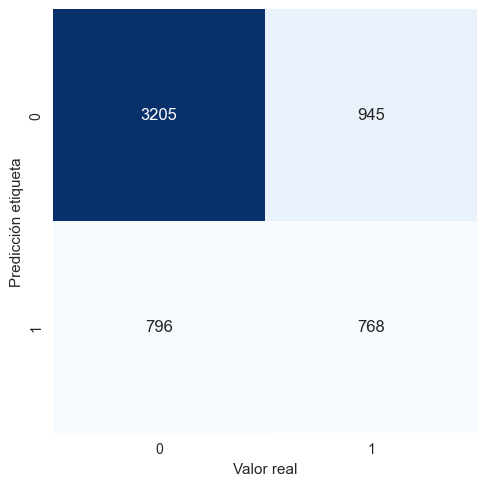

In [14]:
# Matriz de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap = 'Blues')
plt.xlabel('Valor real')
plt.ylabel('Predicción etiqueta');

In [15]:
pred_proba= xgb_model.predict_proba(X_test_scaled_df)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

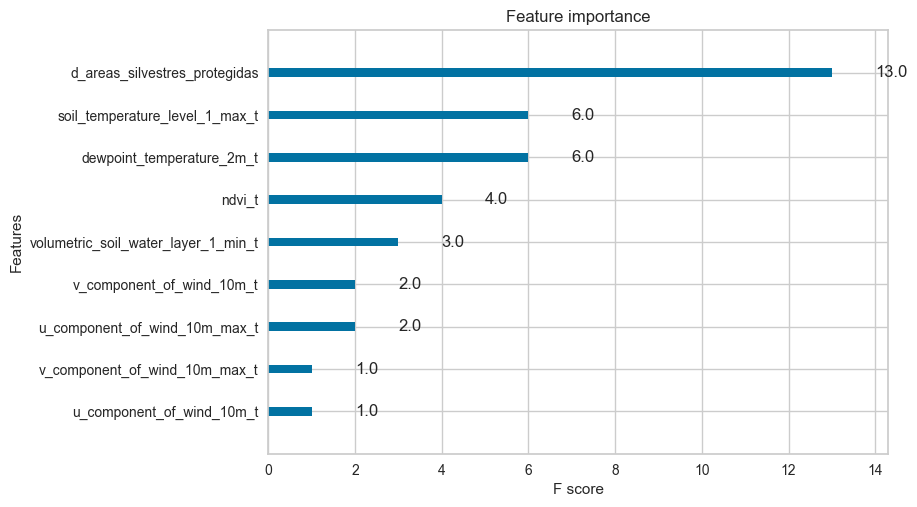

In [16]:
plot_importance(xgb_model, )


Calculando shap values

In [17]:
explainer = shap.Explainer(xgb_model, X_train_scaled_df)

shap_values = explainer.shap_values(X_test_scaled_df)

# primer valor set testeo
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled_df.iloc[0,:])


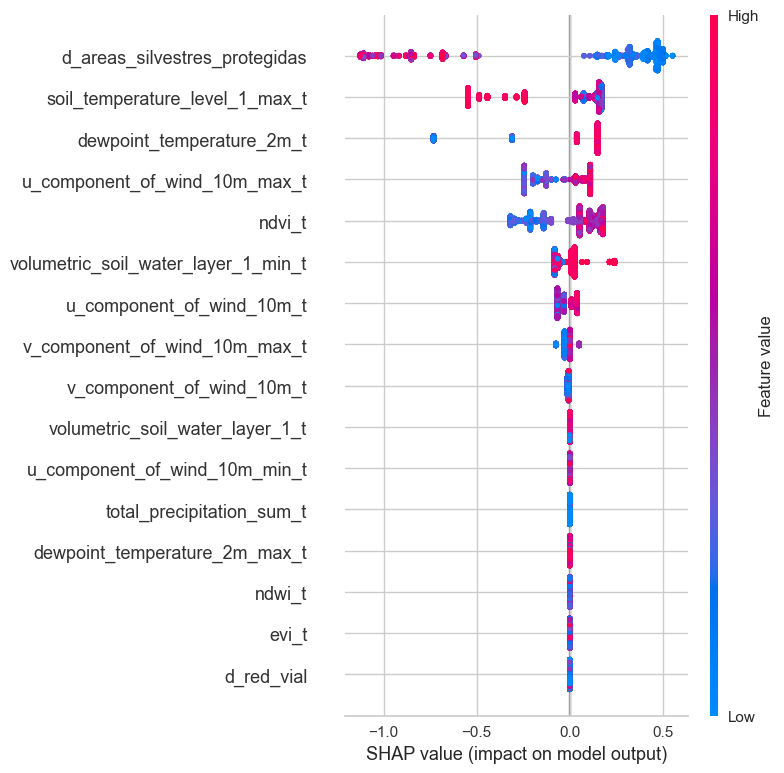

In [18]:
shap.summary_plot(shap_values, X_test_scaled_df)

#### VIZ

In [19]:
prob_pos = pred_proba[:, 1]

In [20]:
X_test.time.value_counts()

time
2022-12-14    2442
2022-12-19    1192
2022-11-19    1116
2023-05-08     964
Name: count, dtype: int64

In [21]:
X_test['prob'] = prob_pos
X_test['y_test'] = y_test

In [22]:
rev_dia = X_test[X_test['time']== '2022-12-19']

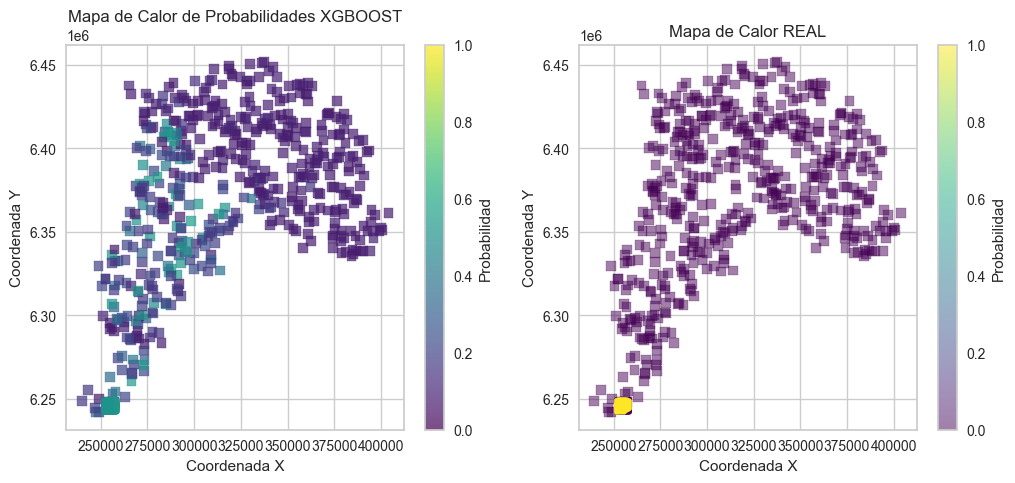

In [23]:
min_prob = min(prob_pos.min(), y_test.min())
max_prob = max(prob_pos.max(), y_test.max())

norm = Normalize(vmin=min_prob, vmax=max_prob)

plt.figure(figsize=(15, 5))


# Subgráfico 2: XGB
plt.subplot(1, 3, 2)
plt.scatter(rev_dia.x, rev_dia.y, c=rev_dia.prob, cmap='viridis', norm=norm, marker='s', s=50, alpha=0.7)
plt.colorbar(label='Probabilidad')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Mapa de Calor de Probabilidades XGBOOST')
plt.grid(True)

# Subgráfico 3: REAL
plt.subplot(1, 3, 3)
plt.scatter(rev_dia.x, rev_dia.y, c=rev_dia.y_test, cmap='viridis', norm=norm, marker='s', s=50, alpha=0.5)
plt.colorbar(label='Probabilidad')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Mapa de Calor REAL')
plt.grid(True)

# Ajustar el espacio entre los subgráficos para evitar superposiciones
plt.tight_layout()

# Mostrar los subgráficos
plt.show()



Guardando predicciones:

In [24]:
X_test['pred_XGB'] = prob_pos
X_test['es_incendio']= y_test
X_test.to_csv('predicciones_test_.csv')

X_test.drop(['pred_XGB'], axis =1)

,time,y,x,id_incendio,fecha_ini,tipo_dato,id_pixel,id_pixel_incendio,d_areas_silvestres_protegidas,d_red_hidrografica,...,u_component_of_wind_10m_min_t,v_component_of_wind_10m_t,v_component_of_wind_10m_max_t,v_component_of_wind_10m_min_t,volumetric_soil_water_layer_1_t,volumetric_soil_water_layer_1_max_t,volumetric_soil_water_layer_1_min_t,prob,y_test,es_incendio
30359,2022-12-14,6429330.0,309390.0,2022-2023-2,2022-12-15,zona_random,46210,2022-2023-2-46210,54629.027255,562.065811,...,-0.658142,0.298810,1.334518,-0.553024,0.144883,0.145050,0.144745,0.079530,0,0
30204,2022-12-14,6363650.0,330990.0,2022-2023-2,2022-12-15,zona_random,46055,2022-2023-2-46055,21828.388837,301.602354,...,-0.135681,1.461468,3.097214,0.239548,0.252268,0.252304,0.252243,0.314498,0,0
31372,2022-12-19,6247550.0,256270.0,2022-2023-3,2022-12-23,zona_incendio,18688,2022-2023-3-18688,13037.087735,1068.017947,...,0.164932,0.287332,0.641068,-0.365189,0.251687,0.251709,0.251663,0.534999,0,0
29978,2022-12-14,6353890.0,402170.0,2022-2023-2,2022-12-15,zona_random,45829,2022-2023-2-45829,89808.252286,422.172314,...,-0.154236,-0.421303,1.200577,-1.246796,0.251345,0.251373,0.251328,0.091848,0,0
31447,2022-12-19,6244390.0,255550.0,2022-2023-3,2022-12-23,zona_incendio,18763,2022-2023-3-18763,16028.204268,863.716645,...,0.164932,0.287332,0.641068,-0.365189,0.251687,0.251709,0.251663,0.499481,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34409,2022-11-19,6332830.0,277570.0,2022-2023-4,2022-11-21,zona_incendio,20487,2022-2023-4-20487,5998.697926,1229.573126,...,0.253799,3.032761,4.287994,1.773987,0.255040,0.255188,0.254669,0.534999,1,1
34416,2022-11-19,6334110.0,277090.0,2022-2023-4,2022-11-21,zona_incendio,20494,2022-2023-4-20494,7054.108832,673.043207,...,0.253799,3.032761,4.287994,1.773987,0.255040,0.255188,0.254669,0.534999,1,1
34421,2022-11-19,6335850.0,278650.0,2022-2023-4,2022-11-21,zona_incendio,20499,2022-2023-4-20499,9165.660898,775.049970,...,0.253799,3.032761,4.287994,1.773987,0.255040,0.255188,0.254669,0.534999,1,1
34422,2022-11-19,6335310.0,277970.0,2022-2023-4,2022-11-21,zona_incendio,20500,2022-2023-4-20500,8510.689644,699.627993,...,0.253799,3.032761,4.287994,1.773987,0.255040,0.255188,0.254669,0.534999,1,1


Guardando modelo:

In [25]:
joblib.dump(xgb_model, 'xgb_model_sin_tiempo.pkl')

# X_train['es_incendio'] = y_train

# aux = {'X_train': X_train , 'X_test': X_test, 'scaler': scaler}
# joblib.dump(aux, 'train_test_scaler.pkl')

['xgb_model_sin_tiempo.pkl']